In [1]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchinfo import summary
from torch.optim import Adam
import torch.nn as nn
import matplotlib.pyplot as plt

from data import OxfordIIITPet
from model import UNet
from train import train, test

import torchmetrics

c:\Users\navpr\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
cuda = torch.cuda.is_available()
print("CUDA Available?", torch.cuda.is_available())
seed = 100
torch.manual_seed(seed)
if cuda:
    torch.cuda.manual_seed(seed)

CUDA Available? True


In [3]:
# Hyperparameters
batch_size = 64
lr = 0.001
epochs = 20

In [4]:
img_dir = 'data/images/'
mask_dir = 'data/annotations/trimaps/'
transform = transforms.Compose([transforms.ToTensor()])
dataset = OxfordIIITPet(img_dir, mask_dir, transform=transform)
dataset_size = len(dataset)
train_size = int(0.8*dataset_size)
test_size = int(0.2*dataset_size)
train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size])

In [5]:
train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

c:\Users\navpr\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\transforms\functional.py:152: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ..\torch\csrc\utils\tensor_numpy.cpp:212.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


Feature batch shape: torch.Size([64, 3, 128, 128])
Labels batch shape: torch.Size([64, 1, 128, 128])


Text(0.5, 1.0, 'Masked Image')

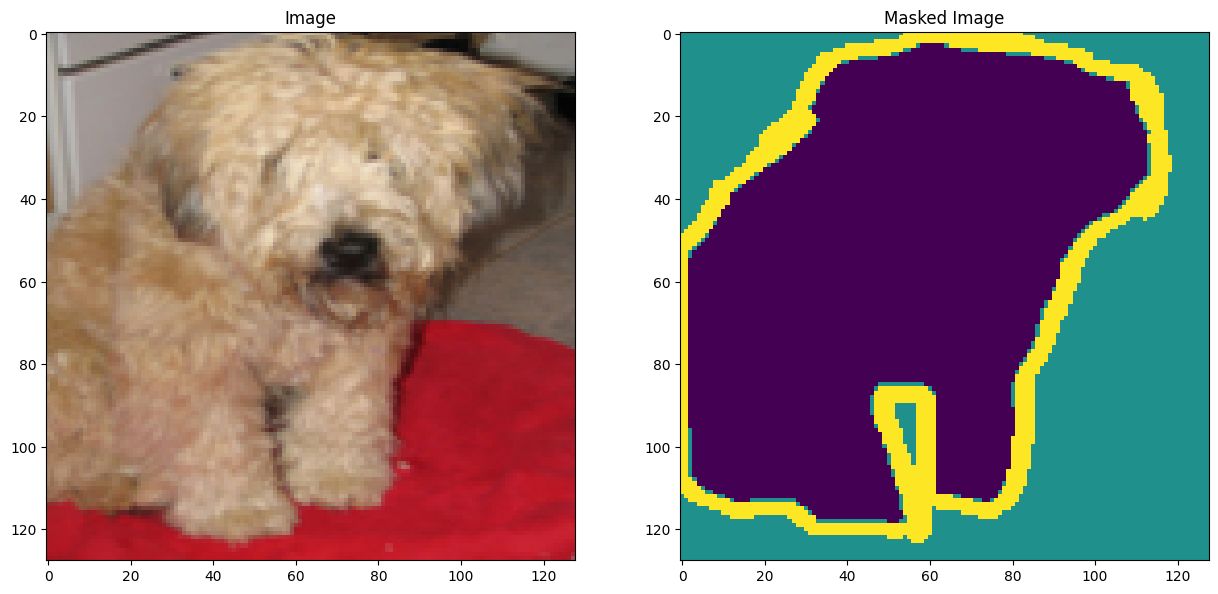

In [6]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0]
mask = train_labels[0].squeeze().numpy()
fig, arr = plt.subplots(1, 2, figsize=(15, 15))
arr[0].imshow(img.permute(1, 2, 0))
arr[0].set_title('Image')
arr[1].imshow(mask)
arr[1].set_title('Masked Image')

# Training 1

In [7]:
model = UNet(3,3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=lr)

summary(model, (1, 3, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [1, 3, 128, 128]          --
├─ContractingBlock: 1-1                  [1, 64, 64, 64]           --
│    └─Conv2d: 2-1                       [1, 64, 128, 128]         1,792
│    └─BatchNorm2d: 2-2                  [1, 64, 128, 128]         128
│    └─ReLU: 2-3                         [1, 64, 128, 128]         --
│    └─Conv2d: 2-4                       [1, 64, 128, 128]         36,928
│    └─BatchNorm2d: 2-5                  [1, 64, 128, 128]         128
│    └─ReLU: 2-6                         [1, 64, 128, 128]         --
│    └─MaxPool2d: 2-7                    [1, 64, 64, 64]           --
├─ContractingBlock: 1-2                  [1, 128, 32, 32]          --
│    └─Conv2d: 2-8                       [1, 128, 64, 64]          73,856
│    └─BatchNorm2d: 2-9                  [1, 128, 64, 64]          256
│    └─ReLU: 2-10                        [1, 128, 64, 64]          --
│

In [8]:
for epoch in range(1,epochs+1):
    print("EPOCH:\n", epoch)
    train(model, device, train_dataloader, optimizer, criterion)
    test(model, device, test_dataloader, criterion)

EPOCH:
 1


Loss=0.5387685298919678 Batch_id=92: 100%|██████████| 93/93 [00:58<00:00,  1.59it/s] 



Test set: Average loss: 0.8497

EPOCH:
 2


Loss=0.3923187553882599 Batch_id=92: 100%|██████████| 93/93 [00:58<00:00,  1.60it/s] 



Test set: Average loss: 0.4688

EPOCH:
 3


Loss=0.352805495262146 Batch_id=92: 100%|██████████| 93/93 [00:58<00:00,  1.60it/s]  



Test set: Average loss: 0.4663

EPOCH:
 4


Loss=0.38325855135917664 Batch_id=92: 100%|██████████| 93/93 [00:57<00:00,  1.62it/s]



Test set: Average loss: 0.3724

EPOCH:
 5


Loss=0.2972753345966339 Batch_id=92: 100%|██████████| 93/93 [00:57<00:00,  1.61it/s] 



Test set: Average loss: 0.3853

EPOCH:
 6


Loss=0.2590520679950714 Batch_id=92: 100%|██████████| 93/93 [00:57<00:00,  1.61it/s] 



Test set: Average loss: 0.3352

EPOCH:
 7


Loss=0.2782839834690094 Batch_id=92: 100%|██████████| 93/93 [00:57<00:00,  1.61it/s] 



Test set: Average loss: 0.3516

EPOCH:
 8


Loss=0.4599181115627289 Batch_id=92: 100%|██████████| 93/93 [00:57<00:00,  1.63it/s] 



Test set: Average loss: 0.3879

EPOCH:
 9


Loss=0.23571579158306122 Batch_id=92: 100%|██████████| 93/93 [00:57<00:00,  1.63it/s]



Test set: Average loss: 0.3248

EPOCH:
 10


Loss=0.24791216850280762 Batch_id=92: 100%|██████████| 93/93 [00:57<00:00,  1.62it/s]



Test set: Average loss: 0.3300

EPOCH:
 11


Loss=0.2749956548213959 Batch_id=92: 100%|██████████| 93/93 [00:56<00:00,  1.63it/s] 



Test set: Average loss: 0.3145

EPOCH:
 12


Loss=0.26476210355758667 Batch_id=92: 100%|██████████| 93/93 [00:57<00:00,  1.62it/s]



Test set: Average loss: 0.2994

EPOCH:
 13


Loss=0.25187259912490845 Batch_id=92: 100%|██████████| 93/93 [00:57<00:00,  1.62it/s]



Test set: Average loss: 0.3215

EPOCH:
 14


Loss=0.30471959710121155 Batch_id=92: 100%|██████████| 93/93 [00:57<00:00,  1.62it/s]



Test set: Average loss: 0.3055

EPOCH:
 15


Loss=0.2415723353624344 Batch_id=92: 100%|██████████| 93/93 [00:57<00:00,  1.61it/s] 



Test set: Average loss: 0.3068

EPOCH:
 16


Loss=0.22082190215587616 Batch_id=92: 100%|██████████| 93/93 [00:57<00:00,  1.62it/s]



Test set: Average loss: 0.2830

EPOCH:
 17


Loss=0.18219459056854248 Batch_id=92: 100%|██████████| 93/93 [00:58<00:00,  1.58it/s]



Test set: Average loss: 0.2901

EPOCH:
 18


Loss=0.25318193435668945 Batch_id=92: 100%|██████████| 93/93 [00:58<00:00,  1.60it/s]



Test set: Average loss: 0.2900

EPOCH:
 19


Loss=0.27469220757484436 Batch_id=92: 100%|██████████| 93/93 [00:58<00:00,  1.59it/s]



Test set: Average loss: 0.3724

EPOCH:
 20


Loss=0.17718560993671417 Batch_id=92: 100%|██████████| 93/93 [00:58<00:00,  1.59it/s]



Test set: Average loss: 0.2946



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature batch shape: torch.Size([64, 3, 128, 128])
Labels batch shape: torch.Size([64, 1, 128, 128])


Text(0.5, 1.0, 'Masked Image')

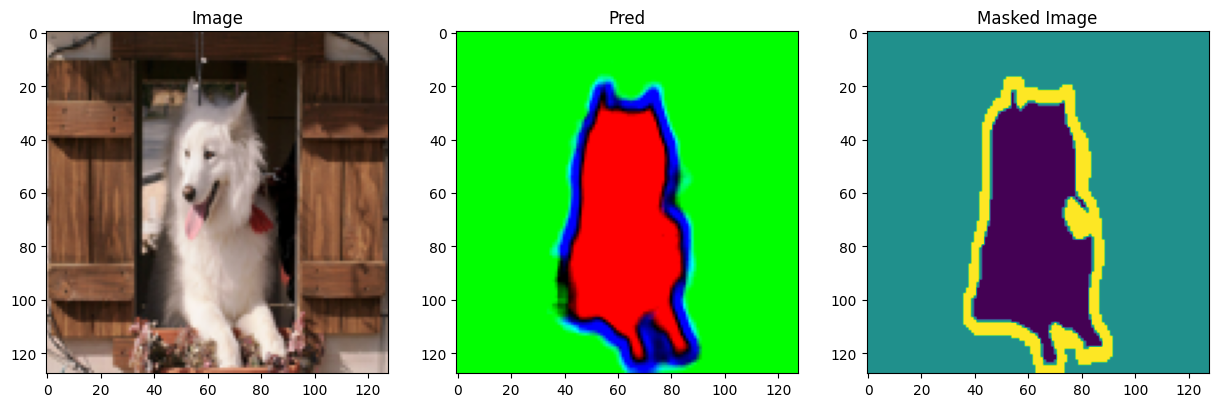

In [9]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0]
pred = model(train_features[0].unsqueeze(0).to(device)).detach().cpu()[0]
mask = train_labels[0].squeeze()
fig, arr = plt.subplots(1, 3, figsize=(15, 15))
arr[0].imshow(img.permute(1, 2, 0))
arr[0].set_title('Image')
arr[1].imshow(pred.permute(1, 2, 0))
arr[1].set_title('Pred')
arr[2].imshow(mask)
arr[2].set_title('Masked Image')

# Training 2

In [10]:
def dice_loss(pred, target, num_classes=3):
    loss=0
    target = torch.nn.functional.one_hot(target, num_classes=3)
    target = target.permute(0,3,1,2)
    for index in range(num_classes):
        loss += dice(target[:,index,:,:], pred[:,index,:,:])
    return loss/num_classes

def dice(pred, target):
    smooth = 1e-5
    # flatten predictions and targets
    pred = pred.contiguous().view(-1)
    target = target.contiguous().view(-1)
    
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    
    dice = (2. * intersection + smooth) / (union + smooth)
    
    return 1 - dice   

In [11]:
model = UNet(3,3).to(device)
criterion = dice_loss
optimizer = Adam(model.parameters(), lr=lr)

summary(model, (1, 3, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [1, 3, 128, 128]          --
├─ContractingBlock: 1-1                  [1, 64, 64, 64]           --
│    └─Conv2d: 2-1                       [1, 64, 128, 128]         1,792
│    └─BatchNorm2d: 2-2                  [1, 64, 128, 128]         128
│    └─ReLU: 2-3                         [1, 64, 128, 128]         --
│    └─Conv2d: 2-4                       [1, 64, 128, 128]         36,928
│    └─BatchNorm2d: 2-5                  [1, 64, 128, 128]         128
│    └─ReLU: 2-6                         [1, 64, 128, 128]         --
│    └─MaxPool2d: 2-7                    [1, 64, 64, 64]           --
├─ContractingBlock: 1-2                  [1, 128, 32, 32]          --
│    └─Conv2d: 2-8                       [1, 128, 64, 64]          73,856
│    └─BatchNorm2d: 2-9                  [1, 128, 64, 64]          256
│    └─ReLU: 2-10                        [1, 128, 64, 64]          --
│

In [12]:
for epoch in range(1,epochs+1):
    print("EPOCH: ", epoch)
    train(model, device, train_dataloader, optimizer, criterion)
    test(model, device, test_dataloader, criterion)

EPOCH:  1


Loss=0.48493140935897827 Batch_id=92: 100%|██████████| 93/93 [00:57<00:00,  1.61it/s]



Test set: Average loss: 0.5278

EPOCH:  2


Loss=0.46499213576316833 Batch_id=92: 100%|██████████| 93/93 [00:58<00:00,  1.60it/s]



Test set: Average loss: 0.4564

EPOCH:  3


Loss=0.07762502133846283 Batch_id=92: 100%|██████████| 93/93 [00:57<00:00,  1.63it/s] 



Test set: Average loss: 0.1024

EPOCH:  4


Loss=0.44981059432029724 Batch_id=92: 100%|██████████| 93/93 [00:56<00:00,  1.64it/s]



Test set: Average loss: 0.4500

EPOCH:  5


Loss=0.44455188512802124 Batch_id=92: 100%|██████████| 93/93 [00:57<00:00,  1.61it/s]



Test set: Average loss: 0.4320

EPOCH:  6


Loss=0.41998371481895447 Batch_id=92: 100%|██████████| 93/93 [00:57<00:00,  1.62it/s]



Test set: Average loss: 0.4203

EPOCH:  7


Loss=0.3724532127380371 Batch_id=92: 100%|██████████| 93/93 [00:56<00:00,  1.64it/s] 



Test set: Average loss: 0.4069

EPOCH:  8


Loss=0.43034300208091736 Batch_id=92: 100%|██████████| 93/93 [00:56<00:00,  1.64it/s]



Test set: Average loss: 0.3955

EPOCH:  9


Loss=0.3710598349571228 Batch_id=92: 100%|██████████| 93/93 [00:56<00:00,  1.65it/s] 



Test set: Average loss: 0.3839

EPOCH:  10


Loss=0.35927852988243103 Batch_id=92: 100%|██████████| 93/93 [00:56<00:00,  1.64it/s]



Test set: Average loss: 0.3741

EPOCH:  11


Loss=0.38532447814941406 Batch_id=92: 100%|██████████| 93/93 [00:56<00:00,  1.64it/s]



Test set: Average loss: 0.3582

EPOCH:  12


Loss=0.27805477380752563 Batch_id=92: 100%|██████████| 93/93 [00:57<00:00,  1.63it/s]



Test set: Average loss: 0.3346

EPOCH:  13


Loss=0.3060084879398346 Batch_id=92: 100%|██████████| 93/93 [00:56<00:00,  1.63it/s]    



Test set: Average loss: 0.1561

EPOCH:  14


Loss=0.6083160638809204 Batch_id=92: 100%|██████████| 93/93 [00:56<00:00,  1.64it/s] 



Test set: Average loss: 0.3639

EPOCH:  15


Loss=0.42859452962875366 Batch_id=92: 100%|██████████| 93/93 [01:02<00:00,  1.50it/s]



Test set: Average loss: 0.3571

EPOCH:  16


Loss=0.3552061915397644 Batch_id=92: 100%|██████████| 93/93 [01:01<00:00,  1.52it/s] 



Test set: Average loss: 0.3548

EPOCH:  17


Loss=0.39980852603912354 Batch_id=92: 100%|██████████| 93/93 [01:00<00:00,  1.53it/s]



Test set: Average loss: 0.3376

EPOCH:  18


Loss=0.40214428305625916 Batch_id=92: 100%|██████████| 93/93 [01:01<00:00,  1.52it/s]



Test set: Average loss: 0.3346

EPOCH:  19


Loss=0.3124183118343353 Batch_id=92: 100%|██████████| 93/93 [01:01<00:00,  1.52it/s] 



Test set: Average loss: 0.3174

EPOCH:  20


Loss=0.21724510192871094 Batch_id=92: 100%|██████████| 93/93 [01:01<00:00,  1.51it/s]



Test set: Average loss: 0.3157



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature batch shape: torch.Size([64, 3, 128, 128])
Labels batch shape: torch.Size([64, 1, 128, 128])


Text(0.5, 1.0, 'Masked Image')

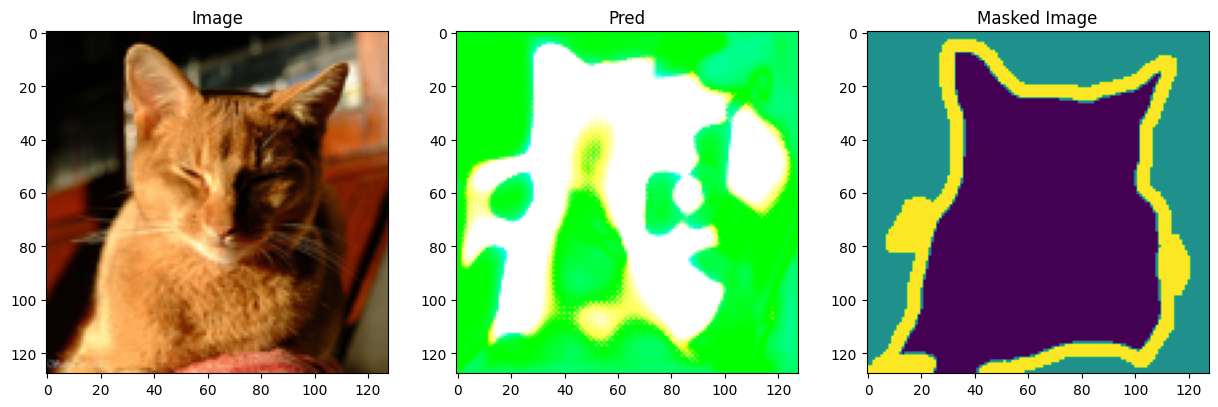

In [13]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0]
pred = model(train_features[0].unsqueeze(0).to(device)).detach().cpu()[0]
mask = train_labels[0].squeeze()
fig, arr = plt.subplots(1, 3, figsize=(15, 15))
arr[0].imshow(img.permute(1, 2, 0))
arr[0].set_title('Image')
arr[1].imshow(pred.permute(1, 2, 0))
arr[1].set_title('Pred')
arr[2].imshow(mask)
arr[2].set_title('Masked Image')

# Training 3

In [14]:
model = UNet(3,3,True).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=lr)

summary(model, (1, 3, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [1, 3, 128, 128]          --
├─ContractingBlock: 1-1                  [1, 64, 64, 64]           --
│    └─Conv2d: 2-1                       [1, 64, 128, 128]         1,792
│    └─BatchNorm2d: 2-2                  [1, 64, 128, 128]         128
│    └─ReLU: 2-3                         [1, 64, 128, 128]         --
│    └─Conv2d: 2-4                       [1, 64, 128, 128]         36,928
│    └─BatchNorm2d: 2-5                  [1, 64, 128, 128]         128
│    └─ReLU: 2-6                         [1, 64, 128, 128]         --
│    └─Conv2d: 2-7                       [1, 64, 64, 64]           16,448
├─ContractingBlock: 1-2                  [1, 128, 32, 32]          --
│    └─Conv2d: 2-8                       [1, 128, 64, 64]          73,856
│    └─BatchNorm2d: 2-9                  [1, 128, 64, 64]          256
│    └─ReLU: 2-10                        [1, 128, 64, 64]          

In [15]:
for epoch in range(1,epochs+1):
    print("EPOCH:\n", epoch)
    train(model, device, train_dataloader, optimizer, criterion)
    test(model, device, test_dataloader, criterion)

EPOCH:
 1


Loss=0.6045262813568115 Batch_id=92: 100%|██████████| 93/93 [01:01<00:00,  1.52it/s]



Test set: Average loss: 0.5610

EPOCH:
 2


Loss=0.47902318835258484 Batch_id=92: 100%|██████████| 93/93 [01:01<00:00,  1.50it/s]



Test set: Average loss: 0.5096

EPOCH:
 3


Loss=0.3920224905014038 Batch_id=92: 100%|██████████| 93/93 [01:01<00:00,  1.52it/s] 



Test set: Average loss: 0.4608

EPOCH:
 4


Loss=0.4605545997619629 Batch_id=92: 100%|██████████| 93/93 [01:00<00:00,  1.53it/s] 



Test set: Average loss: 0.4173

EPOCH:
 5


Loss=0.4044790267944336 Batch_id=92: 100%|██████████| 93/93 [01:00<00:00,  1.53it/s] 



Test set: Average loss: 0.4039

EPOCH:
 6


Loss=0.33137235045433044 Batch_id=92: 100%|██████████| 93/93 [01:01<00:00,  1.52it/s]



Test set: Average loss: 0.3844

EPOCH:
 7


Loss=0.25113776326179504 Batch_id=92: 100%|██████████| 93/93 [01:01<00:00,  1.51it/s]



Test set: Average loss: 0.3641

EPOCH:
 8


Loss=0.27229952812194824 Batch_id=92: 100%|██████████| 93/93 [01:01<00:00,  1.50it/s]



Test set: Average loss: 0.3376

EPOCH:
 9


Loss=0.30555233359336853 Batch_id=92: 100%|██████████| 93/93 [01:01<00:00,  1.50it/s]



Test set: Average loss: 0.4687

EPOCH:
 10


Loss=0.22775985300540924 Batch_id=92: 100%|██████████| 93/93 [01:00<00:00,  1.54it/s]



Test set: Average loss: 0.3216

EPOCH:
 11


Loss=0.30479440093040466 Batch_id=92: 100%|██████████| 93/93 [01:00<00:00,  1.54it/s]



Test set: Average loss: 0.3101

EPOCH:
 12


Loss=0.2710708677768707 Batch_id=92: 100%|██████████| 93/93 [01:00<00:00,  1.53it/s] 



Test set: Average loss: 0.3298

EPOCH:
 13


Loss=0.2894582450389862 Batch_id=92: 100%|██████████| 93/93 [00:58<00:00,  1.58it/s] 



Test set: Average loss: 0.3066

EPOCH:
 14


Loss=0.30719491839408875 Batch_id=92: 100%|██████████| 93/93 [01:00<00:00,  1.54it/s]



Test set: Average loss: 0.3127

EPOCH:
 15


Loss=0.26495614647865295 Batch_id=92: 100%|██████████| 93/93 [01:00<00:00,  1.54it/s]



Test set: Average loss: 0.3023

EPOCH:
 16


Loss=0.2556222677230835 Batch_id=92: 100%|██████████| 93/93 [00:59<00:00,  1.55it/s] 



Test set: Average loss: 0.3103

EPOCH:
 17


Loss=0.3045690953731537 Batch_id=92: 100%|██████████| 93/93 [01:00<00:00,  1.54it/s] 



Test set: Average loss: 0.3369

EPOCH:
 18


Loss=0.2676217555999756 Batch_id=92: 100%|██████████| 93/93 [01:00<00:00,  1.54it/s] 



Test set: Average loss: 0.3084

EPOCH:
 19


Loss=0.24010069668293 Batch_id=92: 100%|██████████| 93/93 [01:00<00:00,  1.54it/s]   



Test set: Average loss: 0.3046

EPOCH:
 20


Loss=0.20800769329071045 Batch_id=92: 100%|██████████| 93/93 [01:00<00:00,  1.54it/s]



Test set: Average loss: 0.2843



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature batch shape: torch.Size([64, 3, 128, 128])
Labels batch shape: torch.Size([64, 1, 128, 128])


Text(0.5, 1.0, 'Masked Image')

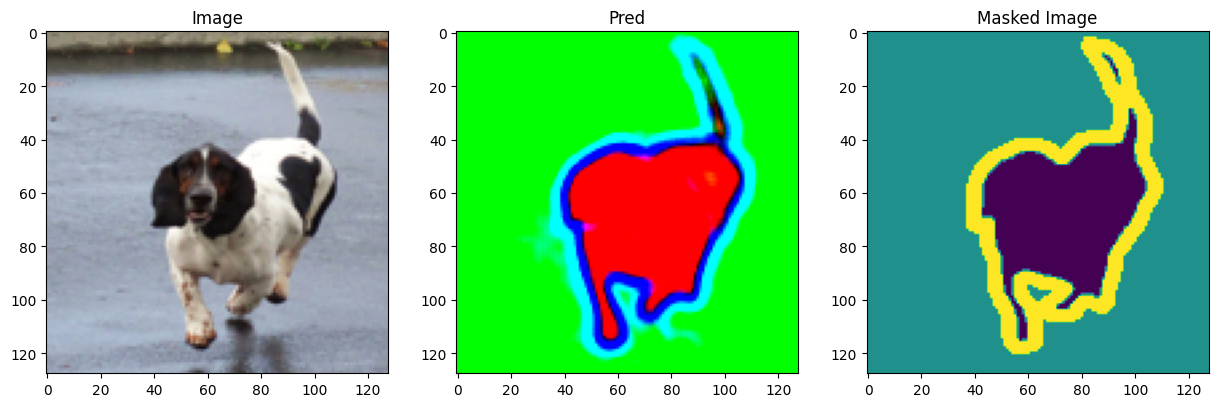

In [16]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0]
pred = model(train_features[0].unsqueeze(0).to(device)).detach().cpu()[0]
mask = train_labels[0].squeeze()
fig, arr = plt.subplots(1, 3, figsize=(15, 15))
arr[0].imshow(img.permute(1, 2, 0))
arr[0].set_title('Image')
arr[1].imshow(pred.permute(1, 2, 0))
arr[1].set_title('Pred')
arr[2].imshow(mask)
arr[2].set_title('Masked Image')

# Training 4

In [17]:
model = UNet(3,3,True,True).to(device)
criterion = dice_loss
optimizer = Adam(model.parameters(), lr=lr)

summary(model, (1, 3, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [1, 3, 128, 128]          --
├─ContractingBlock: 1-1                  [1, 64, 64, 64]           --
│    └─Conv2d: 2-1                       [1, 64, 128, 128]         1,792
│    └─BatchNorm2d: 2-2                  [1, 64, 128, 128]         128
│    └─ReLU: 2-3                         [1, 64, 128, 128]         --
│    └─Conv2d: 2-4                       [1, 64, 128, 128]         36,928
│    └─BatchNorm2d: 2-5                  [1, 64, 128, 128]         128
│    └─ReLU: 2-6                         [1, 64, 128, 128]         --
│    └─Conv2d: 2-7                       [1, 64, 64, 64]           16,448
├─ContractingBlock: 1-2                  [1, 128, 32, 32]          --
│    └─Conv2d: 2-8                       [1, 128, 64, 64]          73,856
│    └─BatchNorm2d: 2-9                  [1, 128, 64, 64]          256
│    └─ReLU: 2-10                        [1, 128, 64, 64]          

In [18]:
for epoch in range(1,epochs+1):
    print("EPOCH:\n", epoch)
    train(model, device, train_dataloader, optimizer, criterion)
    test(model, device, test_dataloader, criterion)

EPOCH:
 1


Loss=0.6905719041824341 Batch_id=92: 100%|██████████| 93/93 [01:00<00:00,  1.55it/s]   



Test set: Average loss: 3.1621

EPOCH:
 2


Loss=0.49383601546287537 Batch_id=92: 100%|██████████| 93/93 [01:00<00:00,  1.54it/s]



Test set: Average loss: 0.5714

EPOCH:
 3


Loss=-0.7889375686645508 Batch_id=92: 100%|██████████| 93/93 [01:00<00:00,  1.54it/s]  



Test set: Average loss: 0.3845

EPOCH:
 4


Loss=0.5852605104446411 Batch_id=92: 100%|██████████| 93/93 [01:00<00:00,  1.54it/s] 



Test set: Average loss: 0.3216

EPOCH:
 5


Loss=-0.33914241194725037 Batch_id=92: 100%|██████████| 93/93 [01:00<00:00,  1.55it/s] 



Test set: Average loss: 0.4451

EPOCH:
 6


Loss=0.5131809711456299 Batch_id=92: 100%|██████████| 93/93 [01:00<00:00,  1.53it/s]  



Test set: Average loss: 0.5934

EPOCH:
 7


Loss=0.4018668830394745 Batch_id=92: 100%|██████████| 93/93 [00:59<00:00,  1.57it/s] 



Test set: Average loss: 0.4338

EPOCH:
 8


Loss=0.007467925548553467 Batch_id=92: 100%|██████████| 93/93 [00:59<00:00,  1.57it/s]



Test set: Average loss: 0.0541

EPOCH:
 9


Loss=0.4504736065864563 Batch_id=92: 100%|██████████| 93/93 [00:58<00:00,  1.60it/s]  



Test set: Average loss: 0.5068

EPOCH:
 10


Loss=0.44260549545288086 Batch_id=92: 100%|██████████| 93/93 [01:00<00:00,  1.55it/s]



Test set: Average loss: 0.4773

EPOCH:
 11


Loss=0.446120023727417 Batch_id=92: 100%|██████████| 93/93 [01:00<00:00,  1.54it/s]  



Test set: Average loss: 0.4233

EPOCH:
 12


Loss=0.3919179439544678 Batch_id=92: 100%|██████████| 93/93 [01:00<00:00,  1.54it/s] 



Test set: Average loss: 0.3925

EPOCH:
 13


Loss=0.36390966176986694 Batch_id=92: 100%|██████████| 93/93 [01:00<00:00,  1.53it/s]



Test set: Average loss: 0.3831

EPOCH:
 14


Loss=0.2933233976364136 Batch_id=92: 100%|██████████| 93/93 [01:00<00:00,  1.53it/s] 



Test set: Average loss: 0.2704

EPOCH:
 15


Loss=0.2547178268432617 Batch_id=92: 100%|██████████| 93/93 [01:02<00:00,  1.49it/s] 



Test set: Average loss: 0.3008

EPOCH:
 16


Loss=0.17127373814582825 Batch_id=92: 100%|██████████| 93/93 [01:01<00:00,  1.52it/s]



Test set: Average loss: 0.0969

EPOCH:
 17


Loss=-0.018977921456098557 Batch_id=92: 100%|██████████| 93/93 [01:02<00:00,  1.50it/s]



Test set: Average loss: 0.2901

EPOCH:
 18


Loss=0.5196123123168945 Batch_id=92: 100%|██████████| 93/93 [01:00<00:00,  1.53it/s]    



Test set: Average loss: 0.4248

EPOCH:
 19


Loss=0.41609010100364685 Batch_id=92: 100%|██████████| 93/93 [01:00<00:00,  1.53it/s]



Test set: Average loss: 0.4436

EPOCH:
 20


Loss=0.3799933195114136 Batch_id=92: 100%|██████████| 93/93 [01:00<00:00,  1.53it/s] 



Test set: Average loss: 0.4408



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature batch shape: torch.Size([64, 3, 128, 128])
Labels batch shape: torch.Size([64, 1, 128, 128])


Text(0.5, 1.0, 'Masked Image')

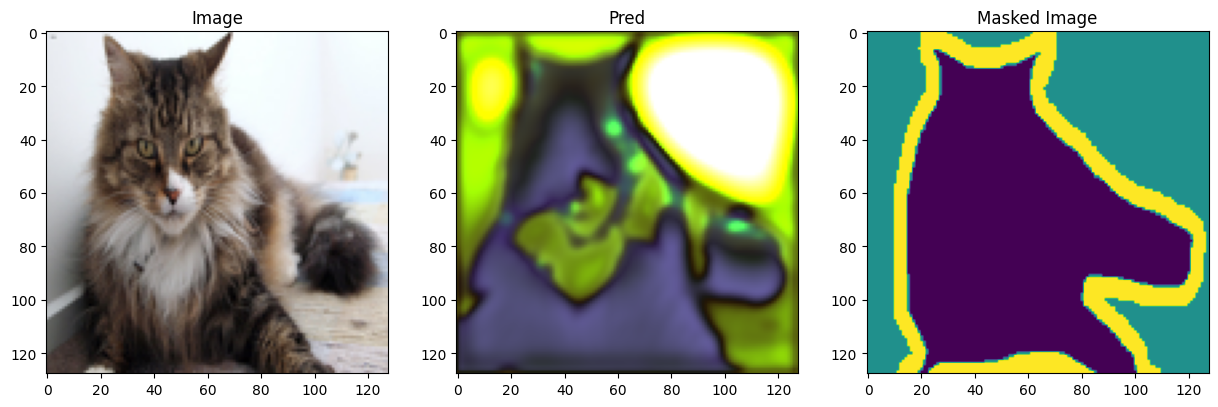

In [19]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0]
pred = model(train_features[0].unsqueeze(0).to(device)).detach().cpu()[0]
mask = train_labels[0].squeeze()
fig, arr = plt.subplots(1, 3, figsize=(15, 15))
arr[0].imshow(img.permute(1, 2, 0))
arr[0].set_title('Image')
arr[1].imshow(pred.permute(1, 2, 0))
arr[1].set_title('Pred')
arr[2].imshow(mask) 
arr[2].set_title('Masked Image')